In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [5]:
length = 100000
train_length = 80000

In [6]:
max_lag = 300

In [7]:
np.random.seed(42)
X0 = 1*np.sin(np.linspace(0, length//10, length)*0.5)*cos(np.linspace(0, length//10, length)*2) + np.random.randn(length)
X1 = 1*np.sin(np.linspace(0, length//10, length)*2) + cos(np.linspace(0, length//10, length)*0.5) + np.random.randn(length)
X2 = np.random.randn(length)
X3 = np.random.randn(length)*0.1
X4 = np.random.randn(length)*0.1
X5 = np.random.randn(length)*0.1
for t in range(max_lag, length):
    X2[t] += X0[t-10]*X1[t-100] + X0[t-70]*X1[t-40]
    X3[t] += X2[t-150]*X1[t-20]-5*np.sin(X0[t-100])
    X4[t] += X3[t-80]/(20 + X2[t-40]) 
    X5[t] += X0[t-10]*X1[t-20]+X2[t-110]*X4[t-120]+X4[t-210]*X5[t-270]

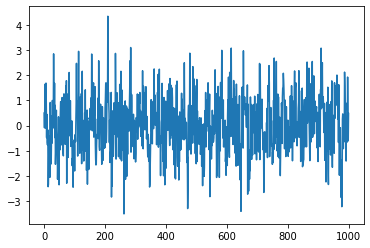

In [8]:
plt.plot(X0[:1000])

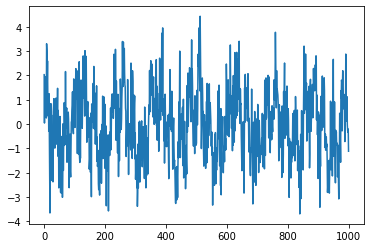

In [9]:
plt.plot(X1[:1000])

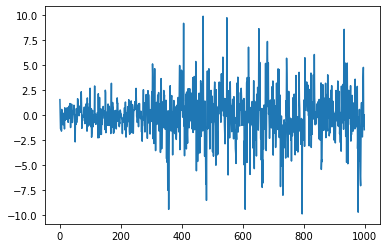

In [10]:
plt.plot(X2[:1000])

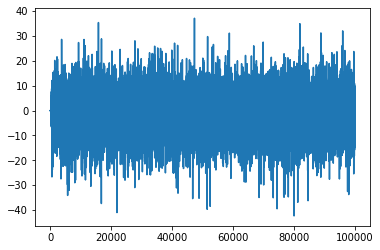

In [11]:
plt.plot(X3[:100000])

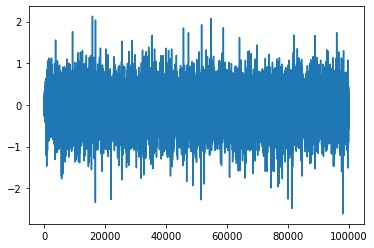

In [12]:
plt.plot(X4)

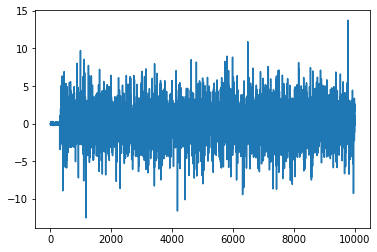

In [13]:
plt.plot(X5[:10000])


In [14]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class TCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.first_layer(x)
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
        x = x[..., -1]
        out = self.output_transform(x)
        return out.squeeze(1)
    
class BidirectionalTCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.forward_tcn = TCN(input_dim, n_layers, n_channels, kernel_size)
        self.backward_tcn = TCN(input_dim, n_layers, n_channels, kernel_size)
        self.output_transform = nn.Linear(2, 1)
    def forward(self, x):
        y = torch.flip(x, (1,))
        out1 = self.forward_tcn(x)
        out2 = self.backward_tcn(y)
        out1 = out1.unsqueeze(1)
        out2 = out2.unsqueeze(1)
        out = torch.cat([out1, out2], dim=1)
        out = self.output_transform(out)
        
        return out.squeeze(1)

In [15]:
depth = 300
epochs = 300
importance_calculation_steps = 20
early_stopping_epochs = 50


In [16]:
from tqdm import tqdm_notebook

In [17]:
X_ = np.concatenate([X0.reshape(-1, 1), 
                    X1.reshape(-1, 1),
                    X2.reshape(-1, 1),
                    X3.reshape(-1, 1),
                    X4.reshape(-1, 1),
                    X5.reshape(-1, 1)], axis=1)

In [18]:
X = np.zeros((len(X_), depth, X_.shape[1]))
for i in range(X_.shape[1]):
    for j in range(depth):
        X[:, j, i] = pd.Series(X_[:, i]).shift(depth - j - 1).bfill()

### Predicting X2

In [19]:
y = pd.Series(X2).shift(-1).ffill().values

In [20]:
X = X[max_lag:]
y = y[max_lag:]

In [21]:
X_train = X[:train_length]
X_test = X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]

In [22]:
X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

In [23]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [24]:
X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

In [25]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [28]:
model = BidirectionalTCN(X_train_t.shape[2], 9).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [30]:
val_loss = 999
counter = 0
for e in range(epochs):
    train_loss = 0
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_bidir_nonlinear_X2.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.006898952089250088 mse:  0.0050549083 r2:  0.0389830677540961


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.004699532358348369 mse:  0.004629987 r2:  0.11976731073650759


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.004566257365792989 mse:  0.0045896037 r2:  0.12744480649254908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.00447367977425456 mse:  0.004240439 r2:  0.1938264385386227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.0035729755509644745 mse:  0.0031336371 r2:  0.4042467143656677


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.002737062310054898 mse:  0.0023439985 r2:  0.554369313150914


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0017142809642478824 mse:  0.0012249858 r2:  0.7671111046524622


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0011091217154636979 mse:  0.001041576 r2:  0.8019801557091892


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.001026668350212276 mse:  0.0011157405 r2:  0.7878803298963238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.0009787458930164575 mse:  0.00096066267 r2:  0.8173630564532679


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0009634441591799259 mse:  0.0009501988 r2:  0.8193523905881837


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.0009529536692425609 mse:  0.0009878451 r2:  0.8121952469412388


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0009570748737081885 mse:  0.000940267 r2:  0.8212405884708197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.000929753920994699 mse:  0.0009402318 r2:  0.8212472857083302


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0009298193129710853 mse:  0.0009496894 r2:  0.8194492395202987


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0009166973661631346 mse:  0.00095183455 r2:  0.8190414170637377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.0009174428110942244 mse:  0.0009977587 r2:  0.8103105270028287


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0009211084173060954 mse:  0.0009099394 r2:  0.8270063396118511


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0009076014522463083 mse:  0.0009424324 r2:  0.8208289055462665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.0009039544795639813 mse:  0.0010090203 r2:  0.8081695110094661


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0008885165782645345 mse:  0.0010435489 r2:  0.8016050666486125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0009041670608334243 mse:  0.00091219036 r2:  0.8265783914387066


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0008969729766249657 mse:  0.0010208465 r2:  0.8059211492622168


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.0009013555694371462 mse:  0.0009997634 r2:  0.809929397231446


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.0008876232897862792 mse:  0.0009723154 r2:  0.8151476945448385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0008957929834723473 mse:  0.00093672 r2:  0.8219149260241831


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0008857989203184843 mse:  0.0009731448 r2:  0.8149900061006774


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0008927440860308707 mse:  0.0009556733 r2:  0.8183116062919786


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.0008861997272819281 mse:  0.0009466086 r2:  0.8200349459654912


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0008803671143949032 mse:  0.0009273403 r2:  0.8236981399132886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0008759981019422412 mse:  0.0009168631 r2:  0.8256900300123635


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0008679654720239341 mse:  0.00096553133 r2:  0.8164374301496901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.000870793478935957 mse:  0.0009726299 r2:  0.8150878904608845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.0008828752937726676 mse:  0.000951816 r2:  0.8190449485418769


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0008741160476580263 mse:  0.000910244 r2:  0.8269484296507819


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0008756779153831304 mse:  0.0009445769 r2:  0.8204212052557891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0008648232417181134 mse:  0.0009162352 r2:  0.8258094063535758


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0008600075021386146 mse:  0.0009098986 r2:  0.8270140933929289


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.000856314139161259 mse:  0.0009901752 r2:  0.811752256971624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0008620199954137206 mse:  0.00089028856 r2:  0.8307422626108976


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0008533157659694553 mse:  0.00097440544 r2:  0.8147503268601686


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0008797425545752049 mse:  0.00097265193 r2:  0.8150836974151721


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.000856962439790368 mse:  0.00093409774 r2:  0.8224134638219772


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.0008609258624725043 mse:  0.0010024249 r2:  0.8094234021494079


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.000867229512706399 mse:  0.0009689689 r2:  0.8157839046014099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.0008538795137777924 mse:  0.0009560743 r2:  0.8182353617771196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.0008477156210690736 mse:  0.0010125634 r2:  0.8074959166148552


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.000843172231130302 mse:  0.0009116845 r2:  0.8266745683455553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0008457482587546111 mse:  0.00090175495 r2:  0.8285623218041296


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0008462068273685872 mse:  0.0009207698 r2:  0.8249473057654844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.0008425301680341363 mse:  0.00095043116 r2:  0.8193082096526534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0008358947345986962 mse:  0.0009705707 r2:  0.8154793577450433


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.0008447848724201321 mse:  0.0009426299 r2:  0.8207913504263457


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.0008401804499328136 mse:  0.0009546566 r2:  0.8185048848568596


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.000833834870159626 mse:  0.0009250844 r2:  0.8241270397622781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0008269337072968483 mse:  0.0009119586 r2:  0.8266224670375457


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0008395535264164209 mse:  0.00089254807 r2:  0.8303127059440968


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.0008322418147698045 mse:  0.00093471276 r2:  0.8222965240810198


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.000827760693244636 mse:  0.00095764885 r2:  0.8179360231592655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0008234887592494487 mse:  0.00097632915 r2:  0.8143846085794392


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.0008214019984006882 mse:  0.00095076713 r2:  0.8192443480158926


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.0008198970267549158 mse:  0.0010600334 r2:  0.7984711084486327


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.0008161568296141923 mse:  0.0009269192 r2:  0.8237782035526136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.000817815744690597 mse:  0.00096341205 r2:  0.8168403609335393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.0007990897553041578 mse:  0.00092327537 r2:  0.8244709565797408


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0008091901647858322 mse:  0.0009699986 r2:  0.8155881518234138


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0007965033825486898 mse:  0.0009583281 r2:  0.8178068953865262


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.000801623937021941 mse:  0.00094912446 r2:  0.8195566316417575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.00079456198643893 mse:  0.0009349545 r2:  0.8222505699336219


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.0007985877072438597 mse:  0.0009696068 r2:  0.8156626274472188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.0007863841783255339 mse:  0.000945297 r2:  0.820284302591357


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.0007866445552557707 mse:  0.00094700546 r2:  0.819959493435658


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.0007717651719227433 mse:  0.00097452075 r2:  0.8147284036252447


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.0007692176960408688 mse:  0.0010100489 r2:  0.8079739633929777


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0007652650685980916 mse:  0.0009867836 r2:  0.8123970317739446


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.0007783517802134156 mse:  0.000993114 r2:  0.8111935476738363


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  0.0007646529132500291 mse:  0.00097299006 r2:  0.8150194340451161


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  0.0007618389543145895 mse:  0.0010197607 r2:  0.8061275810113264


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  0.0007550332829356194 mse:  0.0009930899 r2:  0.8111981415442993


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  0.0007500724132172763 mse:  0.00096258975 r2:  0.8169966897702992


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  80 train:  0.0007448814884759486 mse:  0.0009777647 r2:  0.8141116765608679


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  81 train:  0.0007412707074545324 mse:  0.0009836936 r2:  0.8129845081180771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  82 train:  0.0007499971427954733 mse:  0.0010151308 r2:  0.8070078266161518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  83 train:  0.0007255190510302782 mse:  0.0010345984 r2:  0.8033066829766321


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  84 train:  0.0007326195117086172 mse:  0.0010253437 r2:  0.8050661864677203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  85 train:  0.0007268848503008485 mse:  0.0010117004 r2:  0.8076599845154453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  86 train:  0.0007239155732095241 mse:  0.0010529085 r2:  0.7998256699416174


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  87 train:  0.0007081840564496816 mse:  0.0010161792 r2:  0.8068084855220441


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  88 train:  0.0007105349066667258 mse:  0.0010590424 r2:  0.7986595447528099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  89 train:  0.0007050973309203982 mse:  0.0010470984 r2:  0.8009302457486335


In [31]:
regularizer_coeff1 = 0.0005
regularizer_coeff2 = 0.00001
scaling_coeff = 0.5
importance_lr = 0.1

In [32]:
model.load_state_dict(torch.load("tcn_bidir_nonlinear_X2.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.9520, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9247, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9286, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9489, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9457, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9591, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9545, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9551, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9845, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9455, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8979, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9229, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9185, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9372, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9581, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9518, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9271, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9709, device='cuda:0', grad_fn=<MaxBack

In [33]:
importance_map.max()

0.18319798

([<matplotlib.axis.YTick at 0x7f8dd84e89b0>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

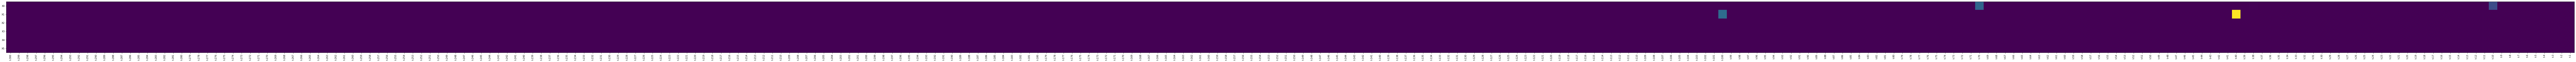

In [35]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance

In [ ]:
#X1[t-100], X0[t-70], X1[t-40], X0[t-10]

### True dependencies


In [54]:
#X2[t] += X0[t-10]*X1[t-100] + X0[t-70]*X1[t-40]

In [55]:
TP = 4
FP = 0
FN = 0
precision1 = TP/(TP + FP + 1e-9)
recall1 = TP/(TP + FN + 1e-9)
precision1, recall1

(0.99999999975, 0.99999999975)

### Predicting X3

In [36]:
y = pd.Series(X3).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [37]:
model = BidirectionalTCN(X_train_t.shape[2], 9).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [39]:
val_loss = 999
counter = 0
#model.load_state_dict(torch.load("tcn_nonlinear_X3.pt"))
for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_bidir_nonlinear_X3.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.003903262908384204 mse:  0.003968751 r2:  -0.0005467059034047761


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.0038715039774775504 mse:  0.0037303006 r2:  0.05956818651756768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.002809754265099764 mse:  0.002118819 r2:  0.46583266163907044


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.002006053586117923 mse:  0.001968691 r2:  0.5036808888798713


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.0019358912605792285 mse:  0.0019354624 r2:  0.5120579504396975


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.001914450941234827 mse:  0.0021284716 r2:  0.46339915781554675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0018611890356987715 mse:  0.001928591 r2:  0.5137902674986341


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0018511837515980006 mse:  0.0019408609 r2:  0.5106969909121108


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.0018264530666172504 mse:  0.0019282886 r2:  0.5138665353456429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.00180133619569242 mse:  0.0018405808 r2:  0.5359782061079893


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.001777138084359467 mse:  0.00180705 r2:  0.5444315387366099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.001785379190929234 mse:  0.0018628058 r2:  0.5303751493637925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.001752846050262451 mse:  0.0018052456 r2:  0.544886440598805


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0017465432725846768 mse:  0.0018044033 r2:  0.5450987721465497


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0017278277752920985 mse:  0.0019297806 r2:  0.5134903996592297


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0017025785520672799 mse:  0.0017580879 r2:  0.5567751903589526


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.0016949873000383377 mse:  0.0017552344 r2:  0.5574945656296229


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0016904913298785686 mse:  0.0017412286 r2:  0.5610254742009753


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0016785893693566322 mse:  0.0017708392 r2:  0.5535605283310605


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.001651600936986506 mse:  0.0017047015 r2:  0.570234238502267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.001649925859645009 mse:  0.0017198998 r2:  0.5664026230748187


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0016395868461579084 mse:  0.0017069214 r2:  0.5696746080461643


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0016443544114008546 mse:  0.0017031427 r2:  0.5706272068217781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.0016294187758117914 mse:  0.0017242958 r2:  0.5652943813022415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.0016179838832467795 mse:  0.001692409 r2:  0.5733332108693652


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0016213835179805756 mse:  0.0018124566 r2:  0.5430684986211081


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.001620481612533331 mse:  0.0017345371 r2:  0.5627125078117505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0016074767092242837 mse:  0.0017032571 r2:  0.5705983656248079


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.001601046158745885 mse:  0.0016990077 r2:  0.5716696383313482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0015919179709628225 mse:  0.0017150252 r2:  0.5676315657304354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0015887653307057918 mse:  0.0016774422 r2:  0.5771064344095735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0015836569575592876 mse:  0.0016675132 r2:  0.5796096461365968


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0015725371956825257 mse:  0.0016727647 r2:  0.5782857043813385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.001554628456197679 mse:  0.0017205551 r2:  0.5662374369070422


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0015155027554370462 mse:  0.0015708 r2:  0.6039916134095964


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0014237237744033336 mse:  0.0014427641 r2:  0.6362702573229781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0012520036494359373 mse:  0.0012385012 r2:  0.6877662232481774


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0011259051110595465 mse:  0.0011945113 r2:  0.6988563331396982


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0010392076645977795 mse:  0.0010744237 r2:  0.7291311604208802


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0009861712944693863 mse:  0.001019315 r2:  0.7430244174371714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.000910236756131053 mse:  0.0008567872 r2:  0.7839986611367133


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0006959611198864877 mse:  0.00050189794 r2:  0.8734684287917797


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.000162239128514193 mse:  5.9404403e-05 r2:  0.9850237843329934


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  5.755315122078173e-05 mse:  3.9551196e-05 r2:  0.9900288982471603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  3.961542134056799e-05 mse:  6.217617e-05 r2:  0.9843250020039197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  3.298582161369268e-05 mse:  3.2972235e-05 r2:  0.9916874954780097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  2.7002932943287304e-05 mse:  2.176663e-05 r2:  0.9945124982490692


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  2.4100312583323103e-05 mse:  1.8273713e-05 r2:  0.9953930845440304


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  2.140861530206166e-05 mse:  2.256595e-05 r2:  0.9943109847091209


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  2.0855819224379956e-05 mse:  3.8713955e-05 r2:  0.9902399738771268


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  2.395346670091385e-05 mse:  1.911487e-05 r2:  0.9951810233509467


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  1.763310790702235e-05 mse:  1.8486891e-05 r2:  0.9953393404645924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  1.5471053947112522e-05 mse:  1.6738077e-05 r2:  0.9957802275846342


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  1.89615425595548e-05 mse:  3.667814e-05 r2:  0.9907532148352534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  1.6451113934454043e-05 mse:  1.8746945e-05 r2:  0.9952737793835086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  2.1508315864775797e-05 mse:  1.6509382e-05 r2:  0.9958378828921289


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  1.9202877648058348e-05 mse:  1.9184276e-05 r2:  0.9951635257869417


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  1.230869873688789e-05 mse:  2.6955433e-05 r2:  0.9932043688724428


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  1.740967615187401e-05 mse:  1.27418725e-05 r2:  0.9967876950468513


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  2.2062478360021485e-05 mse:  1.6142732e-05 r2:  0.9959303175834193


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  1.1005450128868688e-05 mse:  9.689349e-06 r2:  0.9975572552146978


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  1.621115109883249e-05 mse:  1.2003062e-05 r2:  0.9969739542594106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  1.3691323346574791e-05 mse:  1.0211998e-05 r2:  0.9974254919751101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  1.6449347978050354e-05 mse:  1.529243e-05 r2:  0.9961446841686558


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  1.4399416953528999e-05 mse:  1.1881899e-05 r2:  0.9970044999697478


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  1.4567077242827509e-05 mse:  2.3223694e-05 r2:  0.9941451634936822


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  1.3289597556286026e-05 mse:  9.26155e-06 r2:  0.9976651060739137


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  1.2550572660984471e-05 mse:  1.30358685e-05 r2:  0.9967135770530808


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  1.3634291518246754e-05 mse:  1.1267219e-05 r2:  0.9971594644321697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  1.3363688925164751e-05 mse:  1.5959049e-05 r2:  0.9959766253366953


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  1.7206281395920086e-05 mse:  8.950559e-06 r2:  0.9977435086582918


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  1.3570630376489134e-05 mse:  9.028829e-06 r2:  0.9977237766576071


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  2.670731312391581e-05 mse:  1.3978779e-05 r2:  0.9964758632533927


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  1.4006551424972713e-05 mse:  9.549937e-06 r2:  0.9975924018318703


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  1.0083743432187476e-05 mse:  8.91154e-06 r2:  0.9977533455670682


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  1.3746253850695212e-05 mse:  7.7610075e-06 r2:  0.9980434021519163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  1.9781938432424795e-05 mse:  1.3398613e-05 r2:  0.9966221269478933


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  1.8247831023472828e-05 mse:  1.2899336e-05 r2:  0.9967479976983059


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  1.1503023896511877e-05 mse:  1.23001555e-05 r2:  0.9968990548627733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  1.882482929067919e-05 mse:  1.2303113e-05 r2:  0.996898309277469


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  80 train:  1.0635742492013377e-05 mse:  1.1330375e-05 r2:  0.9971435424568627


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  81 train:  1.579821493360214e-05 mse:  2.1262927e-05 r2:  0.9946394845093312


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  82 train:  1.1803226642950904e-05 mse:  8.741294e-06 r2:  0.99779626588913


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  83 train:  1.3264142296975478e-05 mse:  1.5602865e-05 r2:  0.9960664216364455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  84 train:  1.4752225288248155e-05 mse:  2.0701518e-05 r2:  0.9947810194133707


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  85 train:  1.3327894386020489e-05 mse:  1.3376405e-05 r2:  0.9966277255003194


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  86 train:  1.9664176681544632e-05 mse:  3.160291e-05 r2:  0.9920327107782907


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  87 train:  1.400000077992445e-05 mse:  1.1691734e-05 r2:  0.997052441778716


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  88 train:  1.0437232314870925e-05 mse:  1.9548475e-05 r2:  0.9950717086402884


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  89 train:  1.0550299836904742e-05 mse:  8.85068e-06 r2:  0.997768688693852


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  90 train:  9.493256430869223e-06 mse:  8.778411e-06 r2:  0.9977869082994114


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  91 train:  1.5159569677780382e-05 mse:  7.9045974e-05 r2:  0.9800720223341495


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  92 train:  1.8889309818769108e-05 mse:  1.26264895e-05 r2:  0.9968167841074833


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  93 train:  9.72992621245794e-06 mse:  1.6422175e-05 r2:  0.9958598683460194


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  94 train:  1.0462752070452553e-05 mse:  2.7446269e-05 r2:  0.9930806260421913


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  95 train:  1.0262331866397289e-05 mse:  7.061107e-06 r2:  0.9982198511298657


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  96 train:  1.1042191262822598e-05 mse:  9.590541e-06 r2:  0.9975821653763015


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  97 train:  1.1084514801041224e-05 mse:  1.5654061e-05 r2:  0.9960535148293033


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  98 train:  2.0486327781691218e-05 mse:  1.48662875e-05 r2:  0.9962521170868391


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  99 train:  8.31279208578053e-06 mse:  7.865869e-06 r2:  0.9980169660688196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  100 train:  1.349627847012016e-05 mse:  1.3979453e-05 r2:  0.9964756938707235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  101 train:  1.4210002939944388e-05 mse:  2.239803e-05 r2:  0.9943533188665609


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  102 train:  7.929527994565432e-06 mse:  1.0324337e-05 r2:  0.9973971707146353


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  103 train:  1.0602934146299959e-05 mse:  7.776841e-06 r2:  0.9980394104153624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  104 train:  1.0101778076932533e-05 mse:  1.8819155e-05 r2:  0.9952555745392955


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  105 train:  1.2457628855918302e-05 mse:  1.0948086e-05 r2:  0.997239919902313


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  106 train:  9.280893978575477e-06 mse:  6.9767993e-06 r2:  0.9982411058598506


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  107 train:  1.255111545251566e-05 mse:  2.5224495e-05 r2:  0.9936407488171305


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  108 train:  7.3221790771640374e-06 mse:  8.34125e-06 r2:  0.9978971193146192


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  109 train:  1.1724987650814e-05 mse:  7.737758e-06 r2:  0.9980492635142277


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  110 train:  1.2539274743176065e-05 mse:  2.8420705e-05 r2:  0.992834964629479


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  111 train:  9.544501151685836e-06 mse:  1.3773668e-05 r2:  0.9965275732014776


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  112 train:  9.207745138701284e-06 mse:  1.6725902e-05 r2:  0.995783296541215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  113 train:  1.0569405231217388e-05 mse:  2.1405278e-05 r2:  0.9946035971679675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  114 train:  8.87295660431846e-06 mse:  2.3102988e-05 r2:  0.994175593636229


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  115 train:  1.114631324162474e-05 mse:  1.1213248e-05 r2:  0.9971730707598747


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  116 train:  1.0292562464019283e-05 mse:  9.6014355e-06 r2:  0.9975794188990709


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  117 train:  1.4607431936019566e-05 mse:  8.557866e-06 r2:  0.9978425093379558


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  118 train:  8.460598406963982e-06 mse:  1.4041726e-05 r2:  0.9964599943191995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  119 train:  1.5463797792472178e-05 mse:  1.6044089e-05 r2:  0.9959551863564171


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  120 train:  9.716156083595706e-06 mse:  7.572317e-06 r2:  0.9980909722218066


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  121 train:  1.159758415669785e-05 mse:  9.4922125e-06 r2:  0.9976069545206918


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  122 train:  7.537488087109523e-06 mse:  8.777123e-06 r2:  0.9977872330001486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  123 train:  1.2779504031641408e-05 mse:  2.3609204e-05 r2:  0.9940479740340603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  124 train:  1.0553111226909096e-05 mse:  7.632362e-06 r2:  0.9980758340511832


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  125 train:  8.786457718815654e-06 mse:  1.633457e-05 r2:  0.9958819539190278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  126 train:  9.332418935082388e-06 mse:  1.1917657e-05 r2:  0.9969954852019888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  127 train:  1.1432939466612878e-05 mse:  1.10557385e-05 r2:  0.9972127800610827


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  128 train:  8.005650105769746e-06 mse:  2.5424855e-05 r2:  0.9935902378329023


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  129 train:  1.0599524654389825e-05 mse:  8.028285e-06 r2:  0.9979760195877425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  130 train:  1.0142432183783966e-05 mse:  2.8161721e-05 r2:  0.9929002558359805


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  131 train:  1.3349377643316983e-05 mse:  1.207532e-05 r2:  0.9969557370836075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  132 train:  7.942701556748943e-06 mse:  2.2413917e-05 r2:  0.9943493133000625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  133 train:  8.523428189073456e-06 mse:  6.7500428e-06 r2:  0.998298272523928


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  134 train:  1.1832267488352954e-05 mse:  1.1280268e-05 r2:  0.9971561744974012


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  135 train:  7.393604257231345e-06 mse:  6.7462065e-06 r2:  0.9982992397507648


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  136 train:  1.0470844792871503e-05 mse:  7.827655e-06 r2:  0.9980265997000166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  137 train:  1.3635848748526768e-05 mse:  1.3318782e-05 r2:  0.9966422527357709


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  138 train:  6.726585734577384e-06 mse:  6.72876e-06 r2:  0.9983036380263683


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  139 train:  7.527436752570793e-06 mse:  6.8146987e-06 r2:  0.9982819722698487


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  140 train:  9.066991401050473e-06 mse:  3.0072939e-05 r2:  0.9924184262792445


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  141 train:  9.956433975457913e-06 mse:  7.897933e-06 r2:  0.9980088822389821


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  142 train:  1.1152735825453419e-05 mse:  2.1953034e-05 r2:  0.9944655044875771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  143 train:  8.707694304757752e-06 mse:  9.598345e-06 r2:  0.997580197731393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  144 train:  9.329391196661163e-06 mse:  1.0481596e-05 r2:  0.9973575248402576


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  145 train:  7.978000447474188e-06 mse:  1.8511206e-05 r2:  0.995333210650428


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  146 train:  1.4850320020195795e-05 mse:  8.150806e-06 r2:  0.9979451315493754


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  147 train:  6.47584470534639e-06 mse:  8.493004e-06 r2:  0.9978588610835595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  148 train:  7.486420115310466e-06 mse:  8.014286e-06 r2:  0.9979795488736131


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  149 train:  1.3825823600564036e-05 mse:  1.0969724e-05 r2:  0.9972344647766496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  150 train:  9.25650078424951e-06 mse:  1.6594813e-05 r2:  0.9958163447121955


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  151 train:  6.389893143932568e-06 mse:  7.951246e-06 r2:  0.9979954418040883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  152 train:  1.1906169971189229e-05 mse:  1.4090334e-05 r2:  0.9964477399834947


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  153 train:  9.270885911973891e-06 mse:  8.702718e-06 r2:  0.9978059910221267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  154 train:  1.1843423663958674e-05 mse:  1.9784282e-05 r2:  0.9950122602259566


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  155 train:  1.1678358368226327e-05 mse:  1.17795535e-05 r2:  0.9970303017810682


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  156 train:  7.968455887748859e-06 mse:  0.00019869825 r2:  0.9499069434489739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  157 train:  1.5191799482272472e-05 mse:  1.4525672e-05 r2:  0.9963379886036227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  158 train:  7.100327790976735e-06 mse:  5.989132e-06 r2:  0.9984901028478076


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  159 train:  7.879961577418725e-06 mse:  6.8384143e-06 r2:  0.9982759935416103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  160 train:  6.755850202171132e-06 mse:  8.366792e-06 r2:  0.9978906800343613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  161 train:  9.818894044292392e-06 mse:  8.092224e-06 r2:  0.9979599003893759


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  162 train:  1.2874334598745918e-05 mse:  1.2995091e-05 r2:  0.9967238572142902


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  163 train:  7.093831166275777e-06 mse:  1.0235217e-05 r2:  0.9974196385208502


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  164 train:  1.0872622564056655e-05 mse:  2.2835859e-05 r2:  0.9942429384476702


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  165 train:  8.964948502398329e-06 mse:  7.937408e-06 r2:  0.9979989304513565


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  166 train:  5.553589997725794e-06 mse:  1.214611e-05 r2:  0.9969378906395566


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  167 train:  9.293993251776556e-06 mse:  2.1873791e-05 r2:  0.9944854821836203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  168 train:  8.793863263417734e-06 mse:  1.218616e-05 r2:  0.9969277938167374


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  169 train:  7.478915595129365e-06 mse:  1.5177086e-05 r2:  0.9961737627164259


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  170 train:  1.0389655365725047e-05 mse:  2.9498124e-05 r2:  0.9925633403994273


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  171 train:  7.5823040344403125e-06 mse:  1.7003937e-05 r2:  0.9957132025616486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  172 train:  7.310849436908029e-06 mse:  1.0042486e-05 r2:  0.9974682271474204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  173 train:  1.2226988711336162e-05 mse:  7.933797e-06 r2:  0.9979998406227705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  174 train:  7.394392415153561e-06 mse:  9.735831e-06 r2:  0.9975455369935387


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  175 train:  7.190655576414429e-06 mse:  7.2414286e-06 r2:  0.9981743909489965


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  176 train:  5.4051423750934195e-06 mse:  6.4880383e-06 r2:  0.9983643254775891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  177 train:  1.1190202342550038e-05 mse:  7.672564e-06 r2:  0.9980656993767515


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  178 train:  8.028165036375867e-06 mse:  9.838503e-06 r2:  0.9975196526309007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  179 train:  7.77012057515094e-06 mse:  7.0205338e-06 r2:  0.9982300801243359


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  180 train:  1.0028239480743651e-05 mse:  1.565091e-05 r2:  0.9960543088121638


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  181 train:  7.086495690600713e-06 mse:  2.0515057e-05 r2:  0.9948280274699464


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  182 train:  6.0593940448598e-06 mse:  7.4250656e-06 r2:  0.9981280949938639


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  183 train:  8.493282549170545e-06 mse:  1.1948418e-05 r2:  0.9969877300343599


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  184 train:  8.318204424722352e-06 mse:  1.3950869e-05 r2:  0.9964828993318313


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  185 train:  8.265944177401253e-06 mse:  3.208868e-05 r2:  0.99191024613577


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  186 train:  1.0207438188808737e-05 mse:  7.305471e-06 r2:  0.9981582456591271


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  187 train:  5.640557076549157e-06 mse:  5.9396634e-06 r2:  0.998502574276062


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  188 train:  1.101228052575607e-05 mse:  1.3370476e-05 r2:  0.9966292203355595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  189 train:  6.728479114099173e-06 mse:  1.0081296e-05 r2:  0.9974584430629307


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  190 train:  8.391384049173212e-06 mse:  2.521108e-05 r2:  0.9936441306752675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  191 train:  1.0408915790321771e-05 mse:  1.3138086e-05 r2:  0.9966878074997858


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  192 train:  6.310524433501996e-06 mse:  6.152364e-06 r2:  0.9984489509649895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  193 train:  8.19835651491303e-06 mse:  5.0574847e-05 r2:  0.9872497684952996


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  194 train:  1.719021353928838e-05 mse:  1.0125828e-05 r2:  0.9974472161438926


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  195 train:  9.310147419455462e-06 mse:  9.463778e-06 r2:  0.9976141231409965


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  196 train:  6.0080257630033884e-06 mse:  8.035107e-06 r2:  0.9979743000615557


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  197 train:  6.197457320376998e-06 mse:  1.5706904e-05 r2:  0.9960401923944985


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  198 train:  7.589033794647548e-06 mse:  1.2063567e-05 r2:  0.9969587000821722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  199 train:  5.2026584977284075e-06 mse:  6.6303505e-06 r2:  0.998328447749879


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  200 train:  6.453835206048098e-06 mse:  7.4692307e-06 r2:  0.9981169609183931


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  201 train:  8.752069972251775e-06 mse:  7.5418393e-06 r2:  0.998098655573512


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  202 train:  7.156551101797959e-06 mse:  6.2616864e-06 r2:  0.998421390193032


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  203 train:  9.116573555365903e-06 mse:  1.1392881e-05 r2:  0.9971277842299603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  204 train:  6.673265847712173e-06 mse:  4.603085e-06 r2:  0.9988395338498253


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  205 train:  9.413386901724152e-06 mse:  7.5009057e-06 r2:  0.9981089754587714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  206 train:  1.050666951778112e-05 mse:  6.6259804e-06 r2:  0.9983295494802855


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  207 train:  5.535936788510298e-06 mse:  2.0371024e-05 r2:  0.9948643386801704


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  208 train:  8.927548828069121e-06 mse:  8.708718e-06 r2:  0.9978044782552379


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  209 train:  4.505497440550243e-06 mse:  7.896036e-06 r2:  0.998009360659067


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  210 train:  7.822585057874676e-06 mse:  1.1316473e-05 r2:  0.9971470471428412


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  211 train:  6.885441100166645e-06 mse:  7.955832e-06 r2:  0.9979942855184825


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  212 train:  6.30359889328247e-06 mse:  7.652979e-06 r2:  0.998070636929116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  213 train:  1.1872771852358711e-05 mse:  9.113458e-06 r2:  0.9977024408690637


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  214 train:  6.2884259124984964e-06 mse:  6.2038184e-06 r2:  0.9984359791060406


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  215 train:  5.614726569183404e-06 mse:  7.859742e-06 r2:  0.9980185103936164


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  216 train:  8.391013109940105e-06 mse:  2.115931e-05 r2:  0.9946656068884523


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  217 train:  9.334415741250268e-06 mse:  5.539456e-06 r2:  0.9986034688948948


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  218 train:  6.811302796995733e-06 mse:  7.2593148e-06 r2:  0.9981698818695508


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  219 train:  6.515805626986548e-06 mse:  5.9296726e-06 r2:  0.9985050929113735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  220 train:  5.8493940643529645e-06 mse:  6.258059e-06 r2:  0.9984223047040004


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  221 train:  6.570960936369374e-06 mse:  6.2377203e-06 r2:  0.9984274322445009


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  222 train:  8.642845071881311e-06 mse:  8.107167e-06 r2:  0.9979561333107256


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  223 train:  7.886281714309008e-06 mse:  6.0211187e-06 r2:  0.9984820387707554


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  224 train:  6.034890685987193e-06 mse:  8.745753e-06 r2:  0.997795141554722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  225 train:  7.154711705516093e-06 mse:  6.090261e-06 r2:  0.9984646075390399


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  226 train:  8.16811321710702e-06 mse:  7.6132833e-06 r2:  0.9980806442242015


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  227 train:  5.695476668188348e-06 mse:  2.2160933e-05 r2:  0.994413091249038


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  228 train:  6.226656845683465e-06 mse:  6.534328e-06 r2:  0.9983526556319373


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  229 train:  6.718537506094435e-06 mse:  6.9372827e-06 r2:  0.9982510682026886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  230 train:  8.149516541743651e-06 mse:  5.9181157e-06 r2:  0.9985080065048604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  231 train:  5.788496320019476e-06 mse:  8.395735e-06 r2:  0.9978833832997864


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  232 train:  5.663462107622763e-06 mse:  5.6190393e-06 r2:  0.998583405573393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  233 train:  5.505682305374649e-06 mse:  6.7585206e-06 r2:  0.9982961351234779


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  234 train:  6.855662274028873e-06 mse:  6.198967e-06 r2:  0.9984372021202633


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  235 train:  5.875423777615651e-06 mse:  7.616051e-06 r2:  0.9980799464450995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  236 train:  1.054141731292475e-05 mse:  9.833578e-06 r2:  0.9975208944279642


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  237 train:  1.0324502101866528e-05 mse:  1.0040832e-05 r2:  0.9974686443627854


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  238 train:  6.971583983249729e-06 mse:  5.9380773e-06 r2:  0.9985029740349867


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  239 train:  5.981417764269281e-06 mse:  1.3852891e-05 r2:  0.9965076005209698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  240 train:  7.161802835616981e-06 mse:  6.504146e-06 r2:  0.998360264602313


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  241 train:  5.3525027142313775e-06 mse:  1.794539e-05 r2:  0.995475856958483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  242 train:  8.364828530466184e-06 mse:  9.179611e-06 r2:  0.9976857633349707


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  243 train:  6.1800086768926125e-06 mse:  1.7721979e-05 r2:  0.9955321798149085


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  244 train:  4.887038206652505e-06 mse:  5.5960118e-06 r2:  0.99858921096465


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  245 train:  7.163174928427907e-06 mse:  1.8109085e-05 r2:  0.995434587608221


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  246 train:  9.15129908680683e-06 mse:  2.4026183e-05 r2:  0.9939428511282199


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  247 train:  9.447602314321556e-06 mse:  1.1834507e-05 r2:  0.9970164476328697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  248 train:  5.480172680108808e-06 mse:  6.966308e-06 r2:  0.9982437506154959


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  249 train:  4.8368928575655445e-06 mse:  6.227925e-06 r2:  0.998429901663383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  250 train:  5.5781233459129e-06 mse:  6.406138e-06 r2:  0.998384973200751


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  251 train:  5.574016968603246e-06 mse:  8.062327e-06 r2:  0.9979674376280001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  252 train:  9.309025451511843e-06 mse:  8.382483e-06 r2:  0.997886724138665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  253 train:  5.67347935102589e-06 mse:  5.6947874e-06 r2:  0.9985643089128902


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  254 train:  6.1861739613959795e-06 mse:  7.6057418e-06 r2:  0.998082545448029


In [40]:
model.load_state_dict(torch.load("tcn_bidir_nonlinear_X3.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.9324, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9806, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9694, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9576, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9549, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9534, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9539, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9211, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9641, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9521, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9610, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9857, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9028, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9774, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9681, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9739, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9681, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f8d5833fc88>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

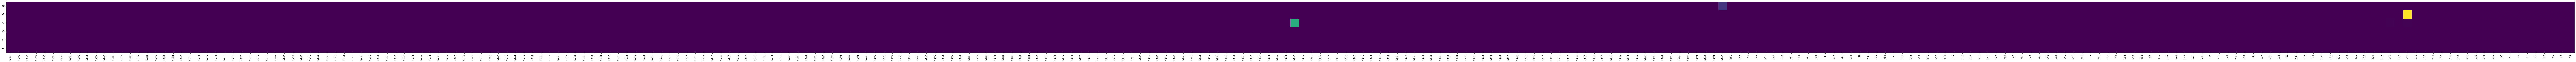

In [42]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### SIgnals with highest importance

In [ ]:
#X2[t-150], X0[t-100], X1[t-20]

### True dependencies

In [56]:
#X3[t] += X2[t-150]*X1[t-20]-5*np.sin(X0[t-100])

In [57]:
TP = 3
FP = 0
FN = 0
precision3 = TP/(TP + FP + 1e-9)
recall3 = TP/(TP + FN + 1e-9)
precision3, recall3

(0.9999999996666666, 0.9999999996666666)

### Predicting X4

In [43]:
y = pd.Series(X4).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [44]:
model = BidirectionalTCN(X_train_t.shape[2], 9).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [45]:
val_loss = 999
counter = 0

for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_nonlinear_bidir_X4.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.004182876314222813 mse:  0.0024870771 r2:  0.35419183217874284


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.0022615928687155246 mse:  0.0022245138 r2:  0.4223705205149083


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.0021832394942641257 mse:  0.0021834052 r2:  0.4330449874612009


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.0021461439300328494 mse:  0.0021567973 r2:  0.43995414713408665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.002123815477080643 mse:  0.0021522364 r2:  0.441138457120394


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.0021012548469007014 mse:  0.0021352663 r2:  0.4455449587117032


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0020726015374064447 mse:  0.001807371 r2:  0.5306880558211348


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0008221098516136408 mse:  0.0006348194 r2:  0.83515929555859


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.0006370095543563366 mse:  0.0006006759 r2:  0.8440251796666565


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.0006221261315047741 mse:  0.00064956455 r2:  0.8313304710753406


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0006074791014194489 mse:  0.0005942931 r2:  0.8456825516594166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.0006091246908530593 mse:  0.000661008 r2:  0.828359014948526


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0006037919896654785 mse:  0.0006181554 r2:  0.8394863542147804


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0005947706768289208 mse:  0.00059855013 r2:  0.8445771786269185


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.000611680456250906 mse:  0.00060628454 r2:  0.8425688105685869


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0005905142867006361 mse:  0.00068287604 r2:  0.8226806429363351


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.0005996981154195965 mse:  0.0005849606 r2:  0.8481059093485244


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0005973957905545831 mse:  0.00060577 r2:  0.8427024204551525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0005975824407301843 mse:  0.0006023044 r2:  0.8436023061138723


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.0005988503423519433 mse:  0.0005901463 r2:  0.8467593582631506


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0006042568900622427 mse:  0.00058473705 r2:  0.8481639534566366


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0005942970190197229 mse:  0.00059071026 r2:  0.8466129197848054


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0005926447235979139 mse:  0.0005854111 r2:  0.8479889207616518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.000589350009150803 mse:  0.00061618007 r2:  0.8399992832058739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.0005950363128446042 mse:  0.0006038494 r2:  0.8432011354159646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0005855573234148324 mse:  0.00058013323 r2:  0.849359400377559


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0005879462557844818 mse:  0.0007461155 r2:  0.8062595288481115


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0005915188306476921 mse:  0.0005909693 r2:  0.8465456570058423


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.000592420420050621 mse:  0.00063742895 r2:  0.8344816886738647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0005842210751026869 mse:  0.0005832123 r2:  0.8485598765718134


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0005796261165291071 mse:  0.00060595555 r2:  0.8426542328204084


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0005847776904702186 mse:  0.00066177745 r2:  0.828159226366276


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0005878970745950938 mse:  0.0005822737 r2:  0.8488035885953866


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.0005854433455504477 mse:  0.00064873655 r2:  0.8315454881442059


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0005839914685115219 mse:  0.0006333038 r2:  0.8355528434052522


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0005806046955287457 mse:  0.0006133824 r2:  0.840725756844811


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.000582948671001941 mse:  0.00060731045 r2:  0.842302415785217


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0005797263843938708 mse:  0.000591403 r2:  0.8464330315918407


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.000582345873862505 mse:  0.00059128925 r2:  0.8464625677275591


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0005756278818938881 mse:  0.0006620612 r2:  0.82808553452862


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0005811572498641909 mse:  0.00060355593 r2:  0.8432773380160156


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0005743505300953984 mse:  0.00058783876 r2:  0.8473585438030112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.0005720399029552936 mse:  0.0006058101 r2:  0.8426920142967245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.0005822550938464701 mse:  0.000595638 r2:  0.845333348487068


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.0005713176894932985 mse:  0.0005955849 r2:  0.8453471376505368


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.00056938441619277 mse:  0.0005941042 r2:  0.8457316449579395


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.0005652387320064008 mse:  0.00061135663 r2:  0.8412517679623746


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.0005698387381620706 mse:  0.00061815593 r2:  0.8394862397098097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0005647661720402539 mse:  0.00062073494 r2:  0.8388165448025247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0005625803698785603 mse:  0.0006124069 r2:  0.8409790456657247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.0005605861694552005 mse:  0.0006603085 r2:  0.8285406526320906


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0005545960384886712 mse:  0.00062444975 r2:  0.8378519401155261


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.0005530199668370187 mse:  0.00060844474 r2:  0.8420078751356785


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.000552253251709044 mse:  0.0006221898 r2:  0.8384387670822717


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.0005520365719683468 mse:  0.00060555857 r2:  0.8427573185248454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.000550344030186534 mse:  0.00062770915 r2:  0.8370055862795938


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0005450579051859677 mse:  0.00063545635 r2:  0.8349939064932963


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.0005480293610133231 mse:  0.0006136151 r2:  0.840665318247461


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.0005427554529160261 mse:  0.00061669684 r2:  0.8398650986471106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0005364209683611989 mse:  0.0006421857 r2:  0.8332465236994712


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.0005408954820595682 mse:  0.0006320985 r2:  0.8358658186965002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.0005378812587819993 mse:  0.00063011097 r2:  0.836381913674183


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.0005317439832724631 mse:  0.00061847985 r2:  0.8394020973198331


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.0005286252916790545 mse:  0.0006223334 r2:  0.8384014736792178


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.000527741267811507 mse:  0.0006633107 r2:  0.8277610997115247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0005269835232757032 mse:  0.0006506942 r2:  0.8310371677906453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0005273651065304876 mse:  0.00065480656 r2:  0.8299693245708885


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.000515889095608145 mse:  0.00065313687 r2:  0.8304028602867382


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.0005151902806945145 mse:  0.00063448003 r2:  0.8352474161859608


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.0005142533615231514 mse:  0.00064232043 r2:  0.8332115394957765


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.0005120422765612602 mse:  0.0006378795 r2:  0.8343647021547779


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.0005106565473601222 mse:  0.00063921825 r2:  0.8340170465865535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.0005039189588278532 mse:  0.0006316853 r2:  0.8359731059341781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.0005017603472806514 mse:  0.0006461175 r2:  0.8322255719332066


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0004999863281846046 mse:  0.00065822754 r2:  0.8290810021155888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.0004940662764944137 mse:  0.0006768309 r2:  0.8242503568182079


In [46]:
model.load_state_dict(torch.load("tcn_nonlinear_bidir_X4.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.6253, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5858, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7217, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6220, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6273, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7116, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8235, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6210, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6266, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6365, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6330, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7371, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6235, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6789, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7005, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5500, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7272, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6096, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f8d5078c860>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

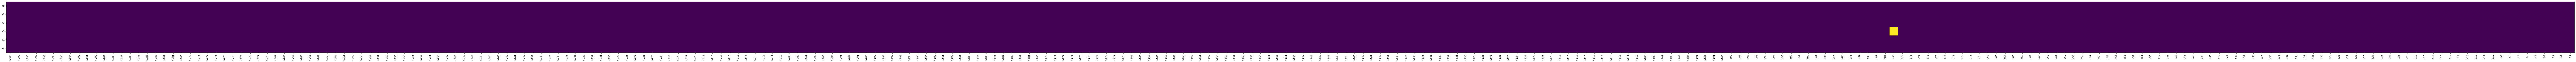

In [47]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance


In [58]:
#X3[t-80]

### True dependencies


In [59]:
#X4[t] += X3[t-80]/(20 + X2[t-40]) 

In [60]:
TP = 1
FP = 0
FN = 1
precision3 = TP/(TP + FP + 1e-9)
recall3 = TP/(TP + FN + 1e-9)
precision3, recall3

(0.9999999989999999, 0.49999999975)

### Predicting X5

In [48]:
y = pd.Series(X5).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [49]:
model = BidirectionalTCN(X_train_t.shape[2], 9).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [51]:
val_loss = 999
counter = 0

for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_nonlinear_bidir_X5.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.004341464406251908 mse:  0.0043175966 r2:  -0.0005818339004264317


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.004088046571612358 mse:  0.0040710066 r2:  0.05656425866073944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.003989026935398579 mse:  0.0041042767 r2:  0.04885419376344535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.003960916381329298 mse:  0.0039796345 r2:  0.07773932158435837


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.00317232513576746 mse:  0.0021943112 r2:  0.4914791799709429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.001505477275699377 mse:  0.0012465504 r2:  0.7111180744454242


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0011415610605850816 mse:  0.0011629807 r2:  0.730484979379928


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0010816430266946554 mse:  0.0012267987 r2:  0.715695409795943


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.0010768892357125878 mse:  0.0010878806 r2:  0.7478890306952267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.001075707922130823 mse:  0.0011393833 r2:  0.7359535350259496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0010474672378972172 mse:  0.0012493033 r2:  0.7104800958559077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.0010493707068264485 mse:  0.0011620024 r2:  0.7307116408957236


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0010385075139813125 mse:  0.0011815311 r2:  0.7261859670177913


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0010324375696480275 mse:  0.001122521 r2:  0.7398613078087815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0010344223785214127 mse:  0.0011386056 r2:  0.736133751557819


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0010377219842746853 mse:  0.0011160632 r2:  0.7413578287148328


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.0010273583309724926 mse:  0.0011409881 r2:  0.7355816379482474


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0010205402163788676 mse:  0.0011625799 r2:  0.7305778321298838


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0010204300433397293 mse:  0.001085342 r2:  0.74847731681788


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.001013756044022739 mse:  0.0011494989 r2:  0.733609263719557


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.001024483853392303 mse:  0.0011862945 r2:  0.7250821153869356


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0010148849321529269 mse:  0.0011178239 r2:  0.7409498438948103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0010225846460089087 mse:  0.0011016908 r2:  0.7446885948465714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.001020852810703218 mse:  0.001128989 r2:  0.7383623692733954


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.0010154973074793816 mse:  0.0011351103 r2:  0.736943824836456


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0010242422161623836 mse:  0.001121971 r2:  0.739988708577618


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0010031483333557843 mse:  0.0010659595 r2:  0.7529691556835939


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0010161080141551794 mse:  0.0010774848 r2:  0.7502982055603603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.001005025196261704 mse:  0.0010768757 r2:  0.7504393514329486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0010019551355391742 mse:  0.0011507906 r2:  0.7333099732383703


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.001008577869273722 mse:  0.0010920038 r2:  0.7469334914145738


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.000997210037894547 mse:  0.0010861431 r2:  0.7482917033070855


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0010033333999104799 mse:  0.0011460511 r2:  0.7344082954785855


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.000998843628540635 mse:  0.001098301 r2:  0.7454741440067203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0010001458507031202 mse:  0.0010723935 r2:  0.7514780838937876


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0010010332142934204 mse:  0.0011515795 r2:  0.7331271019472583


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0009987204728648066 mse:  0.0011107492 r2:  0.7425893472805484


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.000992487807571888 mse:  0.0010685486 r2:  0.7523691099043482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0009918005825951695 mse:  0.0010924966 r2:  0.7468192716639127


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0009950941182672978 mse:  0.0010772059 r2:  0.7503628235619223


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0009845661410130561 mse:  0.0010696148 r2:  0.7521220487228617


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0009924948502331972 mse:  0.0010832058 r2:  0.7489723938750359


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.0009859756503254175 mse:  0.0011116391 r2:  0.7423831019089064


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.000984977231454104 mse:  0.0010809188 r2:  0.7495023969481736


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.000989024730399251 mse:  0.0011146761 r2:  0.74167927016239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.0009776303572580217 mse:  0.0011163513 r2:  0.7412910848677132


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.000982847492583096 mse:  0.0010771549 r2:  0.750374647088749


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.0009853870485909283 mse:  0.0010674057 r2:  0.7526339809609629


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0009816506975330412 mse:  0.0010766123 r2:  0.7505003926357697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0009772175238467753 mse:  0.0010690566 r2:  0.7522514250115961


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.000979541224334389 mse:  0.0010971541 r2:  0.7457399351224272


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0009795430270954967 mse:  0.0011756615 r2:  0.7275462533667836


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.0009777640836313368 mse:  0.0010779714 r2:  0.7501854122705366


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.0009729529960080982 mse:  0.0010828953 r2:  0.7490443428668734


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.0009761428384110331 mse:  0.0010775602 r2:  0.7502807136029388


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0009708985405974091 mse:  0.001101853 r2:  0.7446509996911725


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0009730200991034508 mse:  0.0010837463 r2:  0.7488471354415762


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.0009755965584889054 mse:  0.0011382761 r2:  0.7362101175592459


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.0009735702104866505 mse:  0.0010666972 r2:  0.7527981482328542


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0009635050857439637 mse:  0.00111151 r2:  0.7424130511760594


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.0009631632518023253 mse:  0.0010911872 r2:  0.7471227457409783


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.0009684412144124508 mse:  0.0010869392 r2:  0.7481071749690146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.000960529156960547 mse:  0.0011003372 r2:  0.7450022512284669


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.0009640563208609819 mse:  0.0010932634 r2:  0.7466415984863879


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.0009578650660812854 mse:  0.0010972607 r2:  0.7457152360625428


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0009611377520486712 mse:  0.001131539 r2:  0.7377714022571338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0009556006557308137 mse:  0.0010840496 r2:  0.7487768642004434


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.000963885825034231 mse:  0.0010882396 r2:  0.7478058326152466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.000952017517760396 mse:  0.0010901834 r2:  0.7473553618434235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.0009592820636928082 mse:  0.0010949177 r2:  0.7462582293440019


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.00095326560549438 mse:  0.0010760921 r2:  0.7506209467406724


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.0009499233733862638 mse:  0.0011032007 r2:  0.7443386537278052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.000953613118827343 mse:  0.0011020922 r2:  0.7445955590229771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.0009567303314805031 mse:  0.0010884971 r2:  0.7477461367053332


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0009505058666691185 mse:  0.0010807145 r2:  0.7495497408736799


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.0009468315367586911 mse:  0.0011240569 r2:  0.7395053557683264


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  0.0009521741490811109 mse:  0.0010892616 r2:  0.747568979429043


In [52]:
model.load_state_dict(torch.load("tcn_nonlinear_bidir_X5.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.8772, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9193, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8843, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9077, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8896, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8332, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9127, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8936, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8767, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8070, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8639, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9091, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6158, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9314, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9053, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9112, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7827, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f8d3c43bac8>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

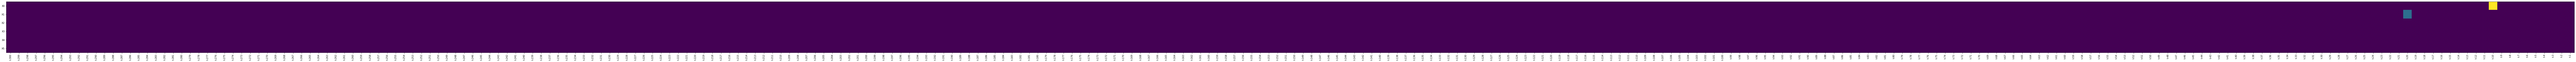

In [61]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance


In [62]:
#X1[t-20], X0[t-10]

### True dependencies

In [63]:
#X5[t] += X0[t-10]*X1[t-20]+X2[t-110]*X4[t-120]+X4[t-210]*X5[t-270]

In [64]:
TP = 2
FP = 0
FN = 4
precision4 = TP/(TP + FP + 1e-9)
recall4 = TP/(TP + FN + 1e-9)
precision4, recall4

(0.9999999995, 0.33333333327777775)